In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
# 导入 matplotlib 模块 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 设置中文字体为黑体 
plt.rcParams['font.sans-serif'] = ['SimHei'] 
# 设置使负号 '-' 正常显示 
plt.rcParams['axes.unicode_minus'] = False 

In [3]:
# 读取数据
file_path = '澳大利亚电力负荷与价格预测数据.xlsx' # 设置文件路径
power_info = pd.read_excel(file_path)
# 检测时间序列是否完整

In [4]:
std_rng = pd.date_range(start='2006-01-01 00:30:00', end='2011-01-01', freq='30min')
print(len(std_rng))
print(len(power_info))

87648
87648


In [5]:
data_daily = pd.DataFrame()
labels_name = ['干球温度', '露点温度', '湿球温度', '湿度', '电价', '电力负荷']
for i, label in enumerate(labels_name):
# 转换为时间序列
    ser = pd.Series(power_info[label].tolist(), index=std_rng)
    data_daily[label] = ser
    
    #data_daily['日类型'] = data_daily.index.dayofweek+1
data_daily

,干球温度,露点温度,湿球温度,湿度,电价,电力负荷
2006-01-01 00:30:00,23.90,21.65,22.40,87.5,19.67,8013.27833
2006-01-01 01:00:00,23.90,21.70,22.40,88.0,18.56,7726.89167
2006-01-01 01:30:00,23.80,21.65,22.35,88.0,19.09,7372.85833
2006-01-01 02:00:00,23.70,21.60,22.30,88.0,17.40,7071.83333
2006-01-01 02:30:00,23.70,21.60,22.30,88.0,17.00,6865.44000
...,...,...,...,...,...,...
2010-12-31 22:00:00,22.60,19.10,20.40,81.0,23.86,8449.54000
2010-12-31 22:30:00,22.45,19.05,20.30,81.5,26.49,8508.16000
2010-12-31 23:00:00,22.30,19.00,20.20,82.0,25.18,8413.14000
2010-12-31 23:30:00,22.05,19.05,20.15,83.5,26.19,8173.79000


In [6]:
std_rng2 = pd.date_range(start='2007-8-1 00:00:00', end='2007-9-1', freq='60min')
std_rng2

DatetimeIndex(['2007-08-01 00:00:00', '2007-08-01 01:00:00',
               '2007-08-01 02:00:00', '2007-08-01 03:00:00',
               '2007-08-01 04:00:00', '2007-08-01 05:00:00',
               '2007-08-01 06:00:00', '2007-08-01 07:00:00',
               '2007-08-01 08:00:00', '2007-08-01 09:00:00',
               ...
               '2007-08-31 15:00:00', '2007-08-31 16:00:00',
               '2007-08-31 17:00:00', '2007-08-31 18:00:00',
               '2007-08-31 19:00:00', '2007-08-31 20:00:00',
               '2007-08-31 21:00:00', '2007-08-31 22:00:00',
               '2007-08-31 23:00:00', '2007-09-01 00:00:00'],
              dtype='datetime64[ns]', length=745, freq='60T')

In [7]:
data_daily2 = data_daily.loc[std_rng2,['干球温度','电力负荷']]
data_daily2

,干球温度,电力负荷
2007-08-01 00:00:00,14.1,9538.26
2007-08-01 01:00:00,14.1,9169.68
2007-08-01 02:00:00,14.3,8755.37
2007-08-01 03:00:00,14.5,7899.77
2007-08-01 04:00:00,14.1,7383.95
...,...,...
2007-08-31 20:00:00,21.4,9311.19
2007-08-31 21:00:00,20.3,9048.19
2007-08-31 22:00:00,19.3,8615.54
2007-08-31 23:00:00,18.0,8773.31


In [8]:
def load_data(df):
    global Max, Min
    columns = df.columns
    Max = np.max(df['电力负荷'])  # 归一化
    Min = np.min(df['电力负荷'])
 
    for i in range(2):
        column = columns[i]
        if column == '电力负荷':
            continue
        df[column] = df[column].astype('float64')
        if len(df[df[column] == 0]) == len(df):  # 全0
            continue
        mx = np.max(df[column])
        mn = np.min(df[column])
        df[column] = (df[column] - mn) / (mx - mn)
    return df

In [9]:
load_data(data_daily2)

,干球温度,电力负荷
2007-08-01 00:00:00,0.358586,9538.26
2007-08-01 01:00:00,0.358586,9169.68
2007-08-01 02:00:00,0.368687,8755.37
2007-08-01 03:00:00,0.378788,7899.77
2007-08-01 04:00:00,0.358586,7383.95
...,...,...
2007-08-31 20:00:00,0.727273,9311.19
2007-08-31 21:00:00,0.671717,9048.19
2007-08-31 22:00:00,0.621212,8615.54
2007-08-31 23:00:00,0.555556,8773.31


In [10]:
def nn_seq():#前24小时负荷+当前时刻温度预测当前时刻负荷
    print('处理数据:')
    data = load_data(data_daily2)
    load = data['电力负荷']
    load = load.tolist()
    load = torch.FloatTensor(load).view(-1)
    #print(load)
    data = data.values.tolist()
    seq = []
    for i in range(len(data) - 24):
        train_seq = []
        train_label = []
        for j in range(i, i + 24):
            train_seq.append(load[j])
        # 添加温度等信息
        for c in range(0, 1):
            train_seq.append(data[i + 24][c])
        train_label.append(load[i + 24])
        train_seq = torch.FloatTensor(train_seq).view(-1)
        train_label = torch.FloatTensor(train_label).view(-1)
        seq.append((train_seq, train_label))
    #print(seq)
    Dtr = seq[0:int(len(seq) * 0.5)]
    Den = seq[int(len(seq) * 0.50):int(len(seq) * 0.75)]
    Dte = seq[int(len(seq) * 0.75):len(seq)]
    return Dtr, Den, Dte

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1d = nn.Conv1d(1, 64, kernel_size=2)
        self.relu = nn.ReLU(inplace=True)
        #输入25-卷积核2+1 = 24 输入通道是1卷积完就是64*24
        self.Linear1 = nn.Linear(64*24, 50)
        self.Linear2 = nn.Linear(50, 1)
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1)
        x = self.Linear1(x)
        x = self.relu(x)
        x = self.Linear2(x)
        return x

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Dtr, Den, Dte = nn_seq()
print(Dte[0])
model = CNN().to(device)
loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(len(Dtr))
epochs = 50
for i in range(epochs):
    print('当前', i)
    cnt = 0
    for x_train, y_train in Dtr:
        x_train, y_train = x_train.to(device), y_train.to(device)
        # 每次更新参数前都梯度归零和初始化
        optimizer.zero_grad()
        # 注意这里要对样本进行reshape，
        # 转换成conv1d的input size（batch size, channel, series
        y_pred = model(x_train.reshape(1, 1, -1))
        loss = loss_function(y_pred, y_train)
        loss.backward()
        optimizer.step()
    print(f'epoch: {i:3} loss: {loss.item():10.10f}')
state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epochs}
torch.save(state, 'LoadCNN')

处理数据:
(tensor([1.0162e+04, 1.0075e+04, 9.9140e+03, 9.8456e+03, 1.0082e+04, 1.0483e+04,
        1.1629e+04, 1.1910e+04, 1.1429e+04, 1.1026e+04, 1.0217e+04, 9.8339e+03,
        9.4092e+03, 8.9837e+03, 8.6161e+03, 7.8238e+03, 7.3452e+03, 7.3595e+03,
        8.0828e+03, 9.7972e+03, 1.0704e+04, 1.0554e+04, 1.0445e+04, 1.0309e+04,
        4.6465e-01]), tensor([10101.7002]))
360
当前 0
epoch:   0 loss: 6869426.0000000000
当前 1
epoch:   1 loss: 168285.8281250000
当前 2
epoch:   2 loss: 336665.1250000000
当前 3
epoch:   3 loss: 613997.7500000000
当前 4
epoch:   4 loss: 22674.9472656250
当前 5
epoch:   5 loss: 4656.1962890625
当前 6
epoch:   6 loss: 91376.9062500000
当前 7
epoch:   7 loss: 17808.4335937500
当前 8
epoch:   8 loss: 26861.7382812500
当前 9
epoch:   9 loss: 2033665.3750000000
当前 10
epoch:  10 loss: 680217.3750000000
当前 11
epoch:  11 loss: 23762.0410156250
当前 12
epoch:  12 loss: 7380.2192382812
当前 13
epoch:  13 loss: 13468.4638671875
当前 14
epoch:  14 loss: 58870.6835937500
当前 15
epoch:  15 loss: 1459.1

In [21]:
def CNN_predict(CNN, test_seq):
    y_pred = []
    y_true = []
    for x_test, y_test in test_seq:
        x_test = x_test.to(device)
        with torch.no_grad():
            y_pred.append(CNN(x_test.reshape(1, 1, -1)).item())
            y_true.append(y_test.item())
    y_pred = np.array([y_pred])
    y_true = np.array([y_true])
    return y_pred,y_true

In [22]:
def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
def mean_squared_error(y_true, y_pred):
    return np.mean(np.square(y_pred - y_true))

In [29]:
def test():
    Dtr, Den, Dte = nn_seq()
    Cnn = CNN().to(device)
    Cnn.load_state_dict(torch.load('LoadCNN')['model'])
    Cnn.eval()
    y_pred,y_true = CNN_predict(Cnn, Dte)
    print(mean_absolute_error(y_true.T, y_pred.T), np.sqrt(mean_squared_error(y_true.T, y_pred.T)))
    plt.plot(y_true.T, label='实际值')
    plt.plot(y_pred.T, label='预测值')
    plt.show()

处理数据:
240.1730242144337 330.82326719447514


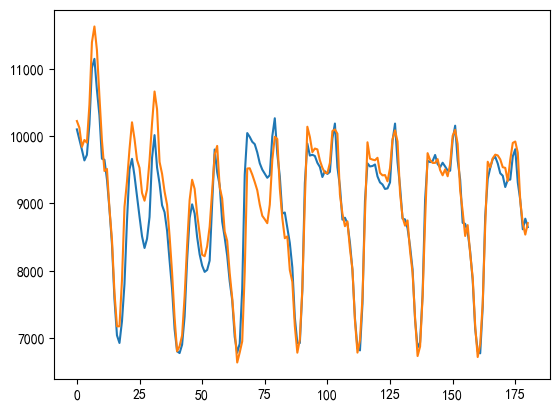

In [30]:
test()